This notebook is designed to be run after another notebook $load_data_w_EDA.ipynb$, which was included in this submission.

# Hailey Weinschenk - BrainStation Capstone Notebook 4 - Card Classification

In this notebook, we will aim to apply deep learning models to solve our classification problem. Namely, we will construct a Convolutional Neural Network (CNN) and train with the goal of correctly identifying the rank and suit (e.g. 9 of clubs, Jack of Diamonds) with a high frequency. This is the final step in our build-from-the-ground-up approach. 

Firstly, we need to import the necessary libraries. Notice the presence of TensorFlow which will be used to construct and fit our CNN. 

In [1]:
from preprocess import preprocess
from helpers import print_accuracy, num_to_card
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import os.path

Contrary to the ML notebooks, we can load the DataFrame directly from *preprocess.py*. This is due to the fact that in TensorFlow, our input should be of the shape $$(# images, x_dimension, y_dimension, # channels)$$ where the number of channels is equivalent 3 for color images and 1 for greyscale. This is different than the ML models, which viewed each pixel as a feature. With 180,000 features, this difference greatly diminishes the scope of our data.

Before discovering a workaround with reading to and from a .csv file and chunking, the preprocessing and loading for the ML models averaged 6 hours and isn't conducive to expedient work. This takes a fraction of that time. Still, be prepared for this to take a few minutes...

In [2]:
x_dim = 216
y_dim = 288
deep = True
df = preprocess(x_dim,y_dim,deep)

In [3]:
df.head()

,img_card_arr,card_class,suit,is_red,suit_num,card_string,card_number
0,"[7, 6, 8, 10, 9, 11, 8, 10, 11, 7, 9, 10, 9, 8...",Queen of Diamonds,Diamonds,1,0,Queen of Diamonds,10
1,"[19, 23, 24, 19, 23, 24, 23, 26, 31, 26, 25, 2...",Queen of Spades,Spades,0,3,Queen of Spades,49
2,"[19, 20, 30, 25, 19, 30, 24, 20, 31, 22, 18, 2...",9 of Clubs,Clubs,0,1,9 of Clubs,20
3,"[33, 36, 34, 31, 34, 32, 31, 34, 32, 30, 35, 3...",9 of Diamonds,Diamonds,1,0,9 of Diamonds,7
4,"[28, 27, 29, 32, 31, 33, 30, 29, 31, 22, 21, 2...",King of Clubs,Clubs,0,1,King of Clubs,24


Now, after viewing the DataFrame we can set our target to be the card_number column. These are encoded with integers from the preprocessing step. They are as follows:
- 0 - 12   ♢ (2 of Diamonds is 0, Ace of Diamonds is 12)
- 13 - 25 ♧ 
- 26 - 38 ♡ 
- 39 - 51 ♤ 
- 52 is Joker class

In [4]:
y = df['card_number']
print(y.shape)
df['card_class'].head(),y.head()

(2756,)


(0    Queen of Diamonds
 1      Queen of Spades
 2           9 of Clubs
 3        9 of Diamonds
 4        King of Clubs
 Name: card_class, dtype: object,
 0    10
 1    49
 2    20
 3     7
 4    24
 Name: card_number, dtype: int64)

Our target vector has the familiar $(# images,)$ shape

Since our `card_img_arr` was flattened during the preprocessing, we need to iterate through and resize to the expected 4-D shape.

In [5]:
reshaped = []
for card_arr_to_resize in df['img_card_arr']:
     reshaped.append( card_arr_to_resize.reshape(x_dim,y_dim,3))
reshaped = np.array(reshaped)
X = reshaped

In [6]:
X.shape # now it is properly ready for modelling!

(2756, 216, 288, 3)

In [7]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = .2,stratify=y)

The train-test split should preserve our shapes...

In [8]:
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')

X_train shape: (2204, 216, 288, 3)
X_test shape: (552, 216, 288, 3)


Similar to before, we scale by modifying the X values to be 0-1 instead of 0-255. However, we have to declare our train and test arrays to be of type float before doing the division. This is different than in the past, because before these were of type DataFrame which handled the conversion.


In [9]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

Finally, we are ready to create the CNN model. This is done manually using Keras layers. So first, we need to import all the necessary layers to be utilized.

In [10]:
# Specific neural network models & layer types
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

Creating a Neural Network based model is an iterative process. First, the framework is created as a `Sequential()` object. Then that framework is populated with 5 different layer types:
- Conv2D: The convolution layer. This makes the model a CNN vs another type of NN. A kernel of a variable size is passed over the image, and one figure is collected that 'summarizes' the grid of pixels beneath.
- MaxPooling2D: This takes the max of the collected tensors from the convolution step explained above. For example, a 4x4 tensor of 24,43,12,and 96 would just become 96. Different types of pooling exist, but for this model we take the max element. 
- Dropout: Randomly drops a percentage of nodes in a neural network to prevent overfitting.
- Flatten: Flattens the output 
- Dense: each neuron receives input from all the neurons of previous layer. Used to classify image based on output from convolutional layers. The last Dense layer has an activation of softmax, which ensures the sum of probabilistic guesses to add up to 1.

In [11]:
CNN_model = Sequential()
num_classes = 53 #all potential cards
# and Dropout to reduce overfitting
CNN_model.add(Conv2D(32, kernel_size=(3, 3), activation = 'relu', input_shape = (216, 288, 3)))
CNN_model.add(MaxPooling2D(pool_size=(2, 2)))
CNN_model.add(Dropout(0.25))

CNN_model.add(Conv2D(64, (3, 3), activation='relu'))
CNN_model.add(MaxPooling2D(pool_size=(2, 2)))
CNN_model.add(Dropout(0.25))

# Flatten the output of our convolutional layers
CNN_model.add(Flatten())

# Add dense layers
CNN_model.add(Dense(128, activation='relu'))
CNN_model.add(Dense(64, activation='relu'))
CNN_model.add(Dense(num_classes, activation='softmax'))

# Print out a summary of the network
CNN_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 214, 286, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 107, 143, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 107, 143, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 105, 141, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 52, 70, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 52, 70, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 232960)            0

2022-07-05 00:14:05.656307: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


The next step is to compile the model. We will briefly touch on these, though they are beyond the scope of this notebook.
- Adam is a powerful, extended version of stochastic gradient descent introduced in 2014.
- sparse_categorical_crossentropy defines the loss function we are minimizing

In [12]:
CNN_model.compile(loss = 'sparse_categorical_crossentropy',
                  optimizer = 'Adam',
                  metrics = ['accuracy'])

Now, the model is fitted and scored. The epoch history is saved for graphing purposes.

In [13]:
model_history = CNN_model.fit(X_train, y_train, 
              batch_size = 25,
              epochs = 20,
              verbose = 1,
              validation_split = 0.2)

Epoch 1/20


2022-07-05 00:14:05.863273: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


71/71 [==============================] - 60s 831ms/step - loss: 6.1911 - accuracy: 0.0263 - val_loss: 3.9017 - val_accuracy: 0.0295
Epoch 2/20
71/71 [==============================] - 61s 859ms/step - loss: 3.6491 - accuracy: 0.0696 - val_loss: 2.9910 - val_accuracy: 0.1519
Epoch 3/20
71/71 [==============================] - 63s 880ms/step - loss: 2.3244 - accuracy: 0.3653 - val_loss: 1.5158 - val_accuracy: 0.5805
Epoch 4/20
71/71 [==============================] - 64s 904ms/step - loss: 0.8976 - accuracy: 0.7336 - val_loss: 0.9992 - val_accuracy: 0.7120
Epoch 5/20
71/71 [==============================] - 62s 877ms/step - loss: 0.3518 - accuracy: 0.9115 - val_loss: 0.8233 - val_accuracy: 0.7574
Epoch 6/20
71/71 [==============================] - 61s 864ms/step - loss: 0.1546 - accuracy: 0.9644 - val_loss: 0.7964 - val_accuracy: 0.7846
Epoch 7/20
71/71 [==============================] - 60s 845ms/step - loss: 0.0654 - accuracy: 0.9859 - val_loss: 0.7482 - val_accuracy: 0.8254
Epoch 8/20

In [14]:
score = CNN_model.evaluate(X_test, y_test, verbose=1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

18/18 [==============================] - 6s 316ms/step - loss: 0.7290 - accuracy: 0.8460
Test loss: 0.7289539575576782
Test accuracy: 0.8460144996643066


Our deep learning model was less accurate than Random Forest from suit classification. There are a myriad hyperparameters that can be adjust to improve this performance, such as batch size, dropout size, validation set size, total epochs, optimizers, etc. but again we are limited by time for repeated runs of this CNN. Gridsearching is unfeasable. Still, this accuracy score is respectable for a classification with such a large number of output classes. Random guessing would spawn a result of $$ 1/53 \approx 2\% $$

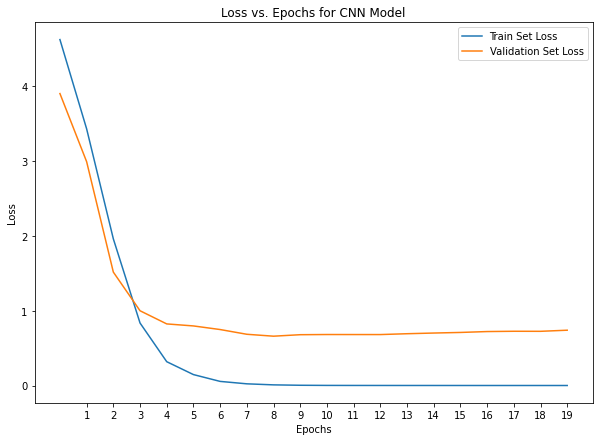

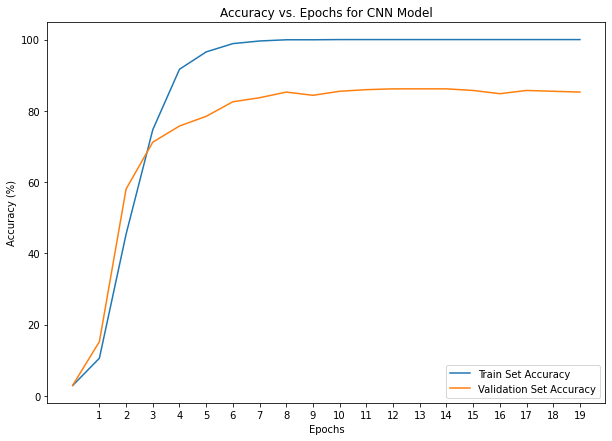

In [15]:
history = model_history.history

loss = history.get('loss')
val_loss = history.get('val_loss')
accuracy = np.array(history.get('accuracy'))*100
val_accuracy = np.array(history.get('val_accuracy'))*100


plt.figure(figsize = (10,7))
plt.plot(loss, label = 'Train Set Loss')
plt.plot(val_loss, label = 'Validation Set Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(np.arange(1,20))
plt.title('Loss vs. Epochs for CNN Model')
plt.show()

plt.figure(figsize = (10,7))
plt.plot(accuracy, label = 'Train Set Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.xticks(np.arange(1,20))
plt.title('Accuracy vs. Epochs for CNN Model')
plt.plot(val_accuracy, label = 'Validation Set Accuracy')
plt.legend()
plt.show()

The training set accuracy quickly rises to 100%. For the testing accuracy, there is a clear leveling off at around 6 or 7 epochs after which, no additional epochs grant more accuracy. This means that our model has learned all it can after a certain amount of passes through our batches.

Next, some insights can be gained into looking where the model predicted incorrectly.

In [16]:
predictions = CNN_model.predict_classes(X_test.reshape(552,216,288,3)) # get predictions
actual = y_test.values # get actual values
max_incorrect = 0
which_wrong = 0
wrong_distance = []
total_wrong = 0
for i in range(0,52): # for each class
    counter = 0
    for j in range(0,552): # for each element of predictions
        if(actual[j] == i and actual[j] != predictions[j]): # if the class is right and the guess was incorrect
            counter +=1
            total_wrong+=1
            wrong_distance.append(np.abs(actual[j] - predictions[j])) # collect distance of 'wrongness'
            if(counter > max_incorrect): # update if more than the worst performing guess
                which_wrong = i
                max_incorrect = counter
avg_wrong_distance = np.sum(np.array(wrong_distance) )/total_wrong       

In [17]:
print(f'The worst performing card was {num_to_card(which_wrong)} with  {max_incorrect} incorrect predictions')
print(f'The total number of wrong guesses was {total_wrong} with an average wrong distance of {avg_wrong_distance}')

The worst performing card was 6 of Clubs with  6 incorrect predictions
The total number of wrong guesses was 84 with an average wrong distance of 15.535714285714286


I was expecting some interesting outputs from this analysis, such as Jokers being often misclassified, but specific card performance seems random and the worst performing card changes each testing iteration. We are limited by the relatively small size of our training set.

Printing out some guesses:

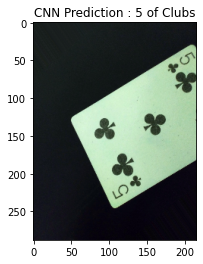

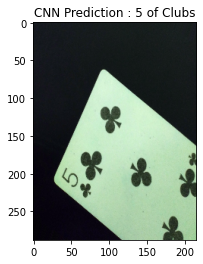

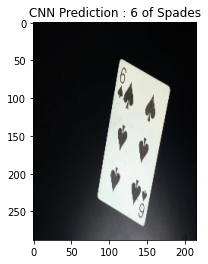

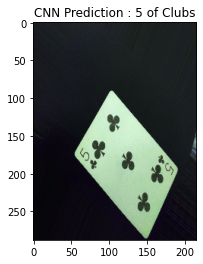

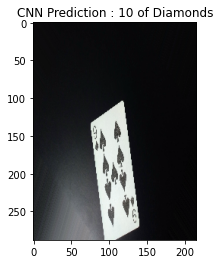

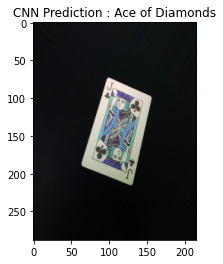

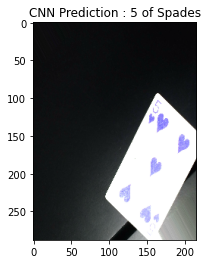

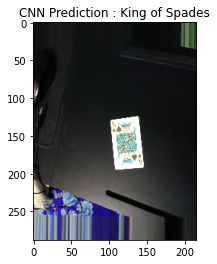

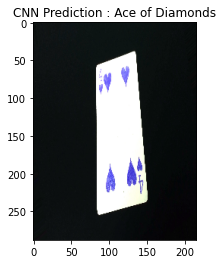

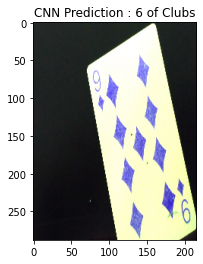

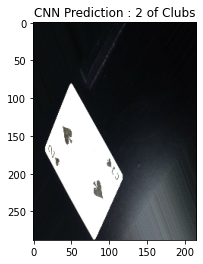

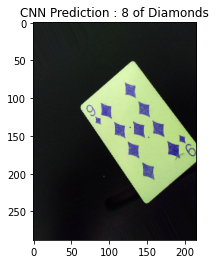

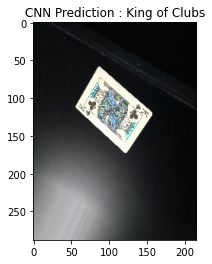

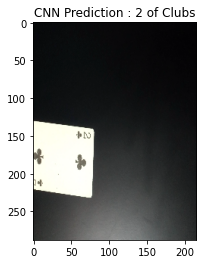

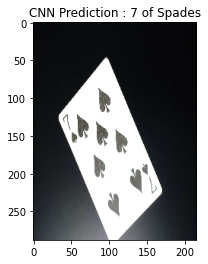

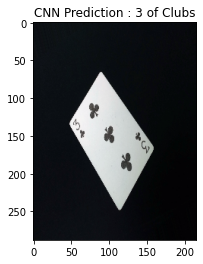

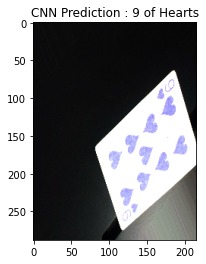

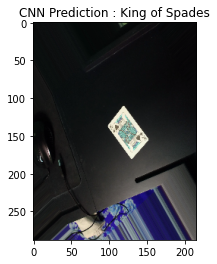

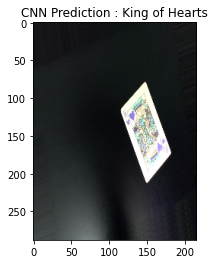

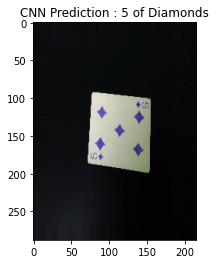

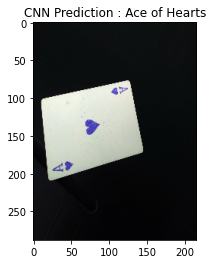

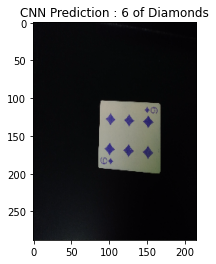

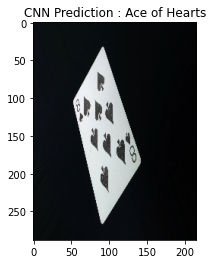

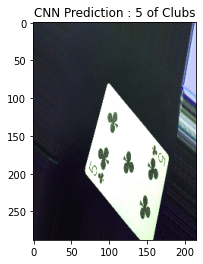

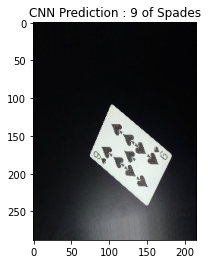

In [18]:
for i in range (0,100,4):
    CNN_card = num_to_card(int(CNN_model.predict_classes(X_test[i].reshape(1,216,288,3))))
    plt.figure()
    plt.title(f'CNN Prediction : {CNN_card}')
    plt.imshow(np.array(X_test[i]).reshape(288,216,3))
    plt.show()

## Random Forest Implementation


Let's circle back to our best performing model, Random Forest. We can try to predict card classes with a ML approach as well.

As mentioned above, we need to reload our data is it is of a fundamentally different shape. This will take around 5 to 7 minutes.

In [19]:
if( os.path.exists('full_preprocessedML.csv')):
    df_chunk = pd.read_csv('full_preprocessedML.csv',index_col=0,iterator=True,chunksize=250)
    df = pd.concat(df_chunk)
else:
   print('Please run load_data_w_EDA.ipynb then rerun this notebook.')

And redefine our target/features...

In [20]:
X_RF = df.iloc[:,2:-5]
y_RF = df['card_number']

Then, train-test split and scale...

In [21]:
X_train_RF,X_test_RF,y_train_RF,y_test_RF = train_test_split(X_RF,y_RF,test_size = .2,stratify=y)
X_train_RF/=255
X_test_RF/=255 

In [22]:
X_train_RF.shape

(2204, 186624)

In the suit classification notebook, we discovered that for this problem, accuracy isn't necessarily improved by having more subtrees. We can create this with 100 subtrees each with 10 depth limit. Then it is time to fit to our training set and score.

In [23]:
from sklearn.ensemble import RandomForestClassifier

#I
my_random_forest=RandomForestClassifier(n_estimators = 100, max_depth = 10)

#F
my_random_forest.fit(X_train_RF,y_train_RF)

#S
print_accuracy(my_random_forest,X_train_RF,X_test_RF,y_train_RF,y_test_RF)

Accuracy on the training set was 0.9941016333938294
Accuracy on the test set was 0.9456521739130435




So clearly, for this problem our Random Forest model had an edge. Regardless, the last step of this project will be to print predictions for our highly successful RF model.

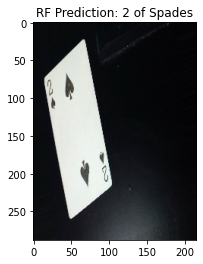

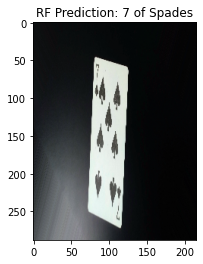

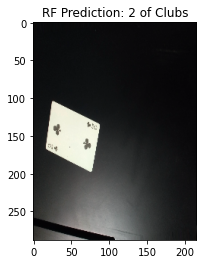

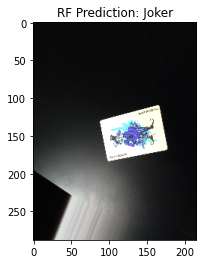

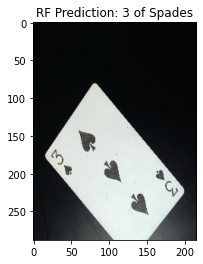

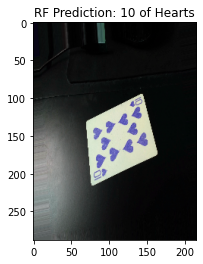

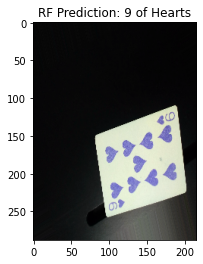

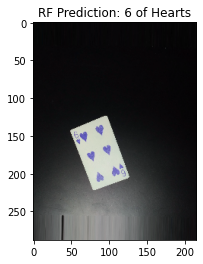

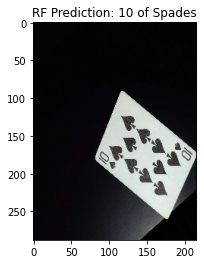

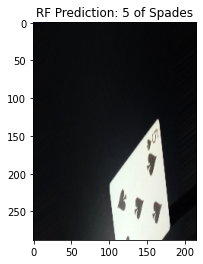

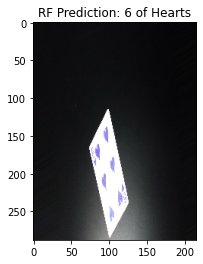

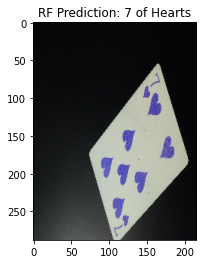

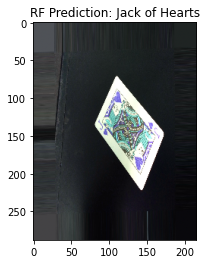

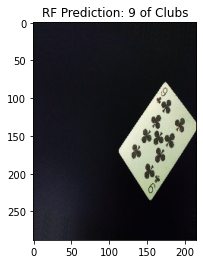

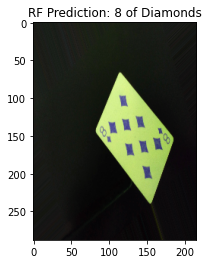

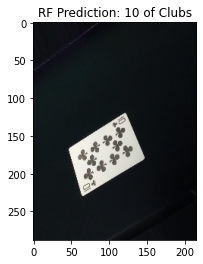

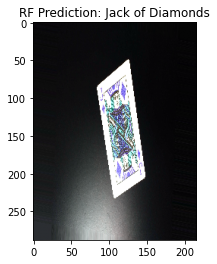

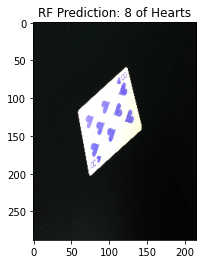

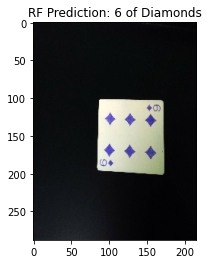

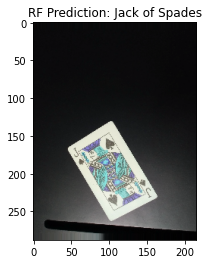

In [24]:
for i in range (0,500,25):
    RF_prediction = my_random_forest.predict([X_test_RF.iloc[i,:]])
    RF_card = num_to_card(int(RF_prediction))
    plt.figure()
    plt.title(f'RF Prediction: {RF_card}')
    plt.imshow(np.array(X_test_RF.iloc[i,:]).reshape(288,216,3))
    plt.show()

**Fin!**  Machine and Deep Learning were used to successfully recognize playing cards!